In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
import keras.backend as K
import pandas as pd
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

Using TensorFlow backend.


In [9]:
def prepare_inputs(X):
    ohe = OneHotEncoder()
    ohe.fit(X)
    X_enc = ohe.transform(X)
    return X_enc

In [10]:
fights_df = pd.read_csv('fights_20210109.csv')
fights_df = fights_df.sample(frac=1).reset_index(drop=True)
fights_df.dropna(inplace=True)

fights_df['a_streak'] = pd.Categorical(fights_df['a_streak'])
a_streak_dummies = pd.get_dummies(fights_df['a_streak'], prefix = 'a_streak')
fights_df['b_streak'] = pd.Categorical(fights_df['a_streak'])
b_streak_dummies = pd.get_dummies(fights_df['b_streak'], prefix = 'b_streak')

fights_df = pd.concat([fights_df, a_streak_dummies], axis=1)
fights_df = pd.concat([fights_df, b_streak_dummies], axis=1)


fights_df = fights_df.drop(columns=['Unnamed: 0', 'a_name', 'b_name', 'a_streak', 'b_streak'])

In [11]:
Y = (fights_df['result'] == 'WIN').astype(int)
X = fights_df.drop(columns=['result'])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, shuffle= True)

In [12]:
def brier_loss(y_true, y_pred):
    brier_loss = K.mean(K.square(y_true - y_pred))
    return brier_loss

In [13]:
model = Sequential()
model.add(Dense(24, input_shape=(x_train.shape[1],), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(6, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(6, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(4, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(1, activation='sigmoid'))

In [14]:
# model.compile(loss=brier_loss, optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# history = model.fit(x_train, y_train, epochs=150, batch_size=256, validation_split=0.05)
# history = model.fit(x_train, y_train, epochs=300, batch_size=512, validation_data=(x_valid, y_valid))
history = model.fit(x_train, y_train, epochs=200, batch_size=512, validation_data=(x_valid, y_valid))

# history = model.fit(X, Y, epochs=30, batch_size=256)

Train on 96984 samples, validate on 10776 samples
Epoch 1/200
96984/96984 [==============================] - 3s 28us/step - loss: 0.6637 - accuracy: 0.6181 - val_loss: 0.6556 - val_accuracy: 0.6102
Epoch 2/200
96984/96984 [==============================] - 2s 17us/step - loss: 0.6288 - accuracy: 0.6439 - val_loss: 0.6357 - val_accuracy: 0.6261
Epoch 3/200
96984/96984 [==============================] - 2s 17us/step - loss: 0.6226 - accuracy: 0.6500 - val_loss: 0.6255 - val_accuracy: 0.6394
Epoch 4/200
96984/96984 [==============================] - 2s 17us/step - loss: 0.6197 - accuracy: 0.6515 - val_loss: 0.6241 - val_accuracy: 0.6385
Epoch 5/200
96984/96984 [==============================] - 2s 17us/step - loss: 0.6168 - accuracy: 0.6554 - val_loss: 0.6160 - val_accuracy: 0.6507
Epoch 6/200
96984/96984 [==============================] - 2s 17us/step - loss: 0.6148 - accuracy: 0.6567 - val_loss: 0.6242 - val_accuracy: 0.6406
Epoch 7/200
96984/96984 [==============================] - 2s 

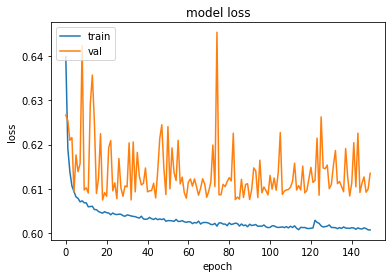

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

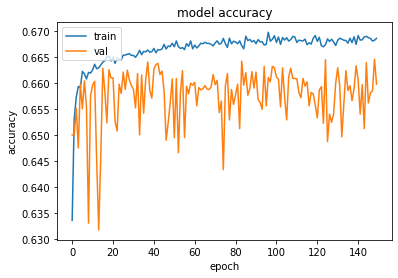

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
pred_all = model.predict(X)
pred_test = model.predict(x_test)

In [12]:
print('All: ' + str(brier_score_loss(Y, pred_all, pos_label=True)))
print('Test: ' + str(brier_score_loss(y_test, pred_test, pos_label=True)))

All: 0.20984385130221
Test: 0.2112248388680036


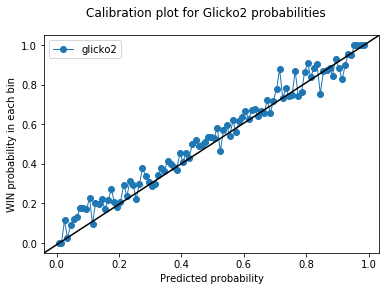

In [13]:
glicko_y, glicko_x = calibration_curve(y_test, pred_test, n_bins=100)

fig, ax = plt.subplots()
# calibration line
plt.plot(glicko_x, glicko_y, marker='o', linewidth=1, label='glicko2')
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Glicko2 probabilities')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('WIN probability in each bin')
plt.legend()
plt.show()

In [14]:
model.save('20210109_3.h5')